In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [4]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [5]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [6]:
observed_ratio = 0.9
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
x_init = copy.deepcopy(x_train)

ground_truth = copy.deepcopy(x_true_img)

In [7]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [8]:
x_miss = image.index_img(x_miss_img,1)

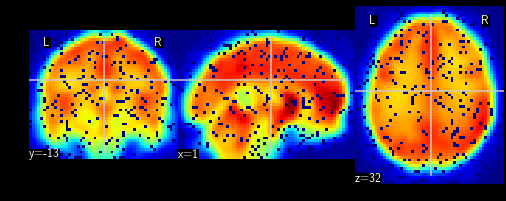

In [9]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [10]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [11]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [12]:
print A

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [13]:
x_train_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [14]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [15]:
normAOmega = t3f.frobenius_norm(A, epsilon=1e-05)
normAOmegavar = tf.get_variable('normAOmega', initializer=normAOmega, trainable=False)

In [16]:
# Algorithm
gradF = X - A
riemannian_grad = t3f.riemannian.project(gradF, X)
F = 0.5 * t3f.frobenius_norm_squared(X - A)
alpha = 0.01
#gradnorm = t3f.frobenius_norm_squared(X - A)/(t3f.frobenius_norm_squared(A))
#gradnorm = t3f.frobenius_norm(X - A,epsilon=1e-05)/(t3f.frobenius_norm(A, epsilon=1e-05))
gradnorm = tf.sqrt((2*F))/(normAOmegavar)

train_step = t3f.assign(X, t3f.round(X - alpha * riemannian_grad, max_tt_rank=63))
rel_error1 = relative_error1(t3f.full(X), t3f.full(A))


In [17]:
eps = 4.0e-4

In [18]:
eps

0.0004

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
log = []
#for i in range(1000):
gradnorm_val = sess.run([gradnorm])
i = 0
while gradnorm_val > eps:    
    i = i + 1
    F_v, rel_error1_v, gradnorm_val,_ = sess.run([F, rel_error1, gradnorm, train_step.op])
    print (F_v, i, gradnorm_val, rel_error1_v)
    log.append(F_v)

(38653405000000.0, 1, 0.117343694, 0.11733481)
(37902260000000.0, 2, 0.11619794, 0.11617663)
(37159250000000.0, 3, 0.11505338, 0.11503027)
(36429900000000.0, 4, 0.11391866, 0.11389537)
(35714863000000.0, 5, 0.112795144, 0.11277209)
(35014130000000.0, 6, 0.11168313, 0.11166021)
(34326557000000.0, 7, 0.11058113, 0.110559486)
(33653428000000.0, 8, 0.109491535, 0.10946989)
(32993136000000.0, 9, 0.10841209, 0.10839074)
(32346750000000.0, 10, 0.10734485, 0.107322656)
(31712027000000.0, 11, 0.10628645, 0.10626501)
(31091071000000.0, 12, 0.1052407, 0.10521799)
(30482033000000.0, 13, 0.10420483, 0.104181744)
(29883843000000.0, 14, 0.103177294, 0.10315529)
(29297216000000.0, 15, 0.102159575, 0.10213941)
(28724560000000.0, 16, 0.10115622, 0.101134054)
(28162990000000.0, 17, 0.10016253, 0.10013909)
(27611883000000.0, 18, 0.09917767, 0.099154)
(27070745000000.0, 19, 0.09820102, 0.098179035)
(26540550000000.0, 20, 0.0972346, 0.09721321)
(26021920000000.0, 21, 0.09627988, 0.09625735)
(25513056000000.

(1437486300000.0, 173, 0.022629123, 0.022622103)
(1411850700000.0, 174, 0.022426438, 0.022419836)
(1386569000000.0, 175, 0.022224737, 0.022219438)
(1362071800000.0, 176, 0.022027535, 0.022020914)
(1337833200000.0, 177, 0.02183066, 0.021824371)
(1314168900000.0, 178, 0.021636723, 0.021629985)
(1291022000000.0, 179, 0.02144533, 0.021437997)
(1268103500000.0, 180, 0.021254126, 0.02124728)
(1245752200000.0, 181, 0.021065982, 0.021058163)
(1223743500000.0, 182, 0.020879067, 0.020871611)
(1202300100000.0, 183, 0.02069533, 0.020686854)
(1180931700000.0, 184, 0.020510595, 0.020503767)
(1160210800000.0, 185, 0.020329857, 0.020322671)
(1139882600000.0, 186, 0.02015097, 0.02014343)
(1119922300000.0, 187, 0.01997376, 0.019966148)
(1100220600000.0, 188, 0.019797292, 0.01979028)
(1080872500000.0, 189, 0.019622445, 0.019616064)
(1061904250000.0, 190, 0.019449506, 0.019443551)
(1043474700000.0, 191, 0.019279992, 0.019273087)
(1025170600000.0, 192, 0.019110145, 0.019104308)
(1007334000000.0, 193, 0.018

(97169195000.0, 343, 0.0058834245, 0.0058783484)
(95782640000.0, 344, 0.005841297, 0.005836031)
(94403480000.0, 345, 0.0057990905, 0.005793534)
(93054600000.0, 346, 0.0057575116, 0.005751801)
(91707220000.0, 347, 0.0057156766, 0.0057102093)
(90372860000.0, 348, 0.005673942, 0.0056689205)
(89067610000.0, 349, 0.005632819, 0.00562799)
(87778950000.0, 350, 0.005591922, 0.0055873333)
(86515835000.0, 351, 0.0055515426, 0.0055469857)
(85259340000.0, 352, 0.005511082, 0.005506523)
(84028120000.0, 353, 0.005471145, 0.005466747)
(82824310000.0, 354, 0.005431813, 0.0054271203)
(81630550000.0, 355, 0.0053925263, 0.0053878315)
(80436716000.0, 356, 0.005352949, 0.005348599)
(79268290000.0, 357, 0.005313928, 0.005309694)
(78128050000.0, 358, 0.00527557, 0.0052712453)
(77003070000.0, 359, 0.0052374504, 0.005233018)
(75892376000.0, 360, 0.0051995404, 0.005194887)
(74796520000.0, 361, 0.005161864, 0.0051571694)
(73721000000.0, 362, 0.0051246183, 0.005119496)
(72624490000.0, 363, 0.005086364, 0.00508213

(5855646000.0, 513, 0.0014442864, 0.0014404247)
(5743806500.0, 514, 0.0014304273, 0.0014265645)
(5635661300.0, 515, 0.0014168972, 0.001412868)
(5527168500.0, 516, 0.0014031925, 0.0013992598)
(5425452500.0, 517, 0.0013902212, 0.0013858668)
(5317894700.0, 518, 0.0013763717, 0.0013725531)
(5218283500.0, 519, 0.0013634202, 0.0013596232)
(5119727600.0, 520, 0.0013504836, 0.0013464987)
(5021656000.0, 521, 0.0013374864, 0.001333557)
(4927879000.0, 522, 0.0013249391, 0.0013206505)
(4832850000.0, 523, 0.0013121018, 0.0013078947)
(4739171300.0, 524, 0.0012993229, 0.0012952981)
(4648438000.0, 525, 0.0012868247, 0.001282888)
(4559027700.0, 526, 0.001274389, 0.0012704646)
(4472596000.0, 527, 0.001262251, 0.0012581829)
(4386849000.0, 528, 0.0012500926, 0.0012459602)
(4305911000.0, 529, 0.0012385068, 0.0012340206)
(4223016200.0, 530, 0.0012265274, 0.0012220908)
(4142256000.0, 531, 0.0012147429, 0.0012102224)
(4062286600.0, 532, 0.0012029599, 0.0011983531)
(3986283800.0, 533, 0.0011916535, 0.001186850

In [20]:
estimated_val = sess.run(t3f.full(X))

In [21]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [22]:
rel_error = relative_error(estimated_val,ground_truth)

In [23]:
rel_error

0.003023469

In [24]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [25]:
x_miss = image.index_img(x_miss_img,1)

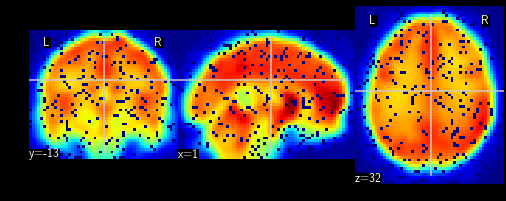

In [26]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

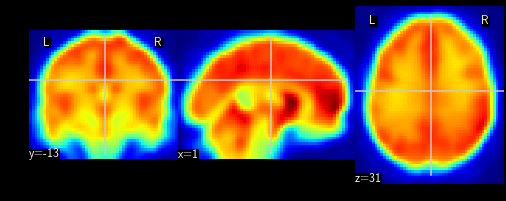

In [27]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, estimated_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

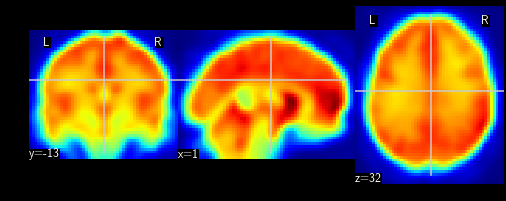

In [28]:
x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [32]:
import mri_draw_utils as mrd

In [29]:
images_folder = "/work/scratch/tt"

In [33]:
mrd.draw_original_vs_reconstructed_rim(x_true_org_img, x_hat, x_miss, "Rim", rel_error, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt/missing_ratio_10.00.png')
Called from mrd
